In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score 

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn import tree
from matplotlib.colors import ListedColormap

from lightgbm import LGBMClassifier

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

/kaggle/input/mlbio1/test.csv
/kaggle/input/mlbio1/train.csv
/kaggle/input/mlbio1/sample_submission.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sample = pd.read_csv('/kaggle/input/mlbio1/sample_submission.csv')
test = pd.read_csv('/kaggle/input/mlbio1/test.csv')
train = pd.read_csv('/kaggle/input/mlbio1/train.csv')

In [4]:
#vieving what kind of data I have

In [5]:
sample

,id,stroke
0,37061,0.5
1,42333,0.5
2,58964,0.5
3,34063,0.5
4,43682,0.5
...,...,...
13395,56196,0.5
13396,5450,0.5
13397,28375,0.5
13398,27973,0.5


In [6]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [7]:
#draving different plots in order to obtain some dependencies

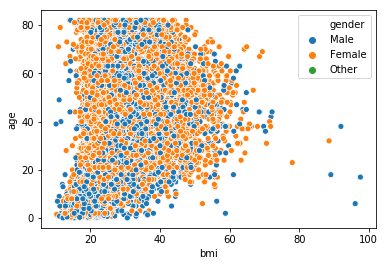

In [8]:
sns.scatterplot(x=train['bmi'], y=train['age'], hue=train['gender'])

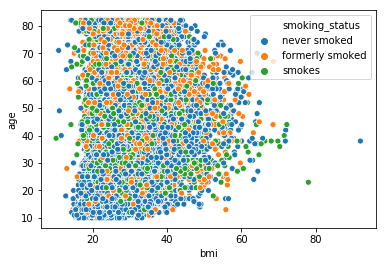

In [9]:
sns.scatterplot(x=train['bmi'], y=train['age'], hue=train['smoking_status'])

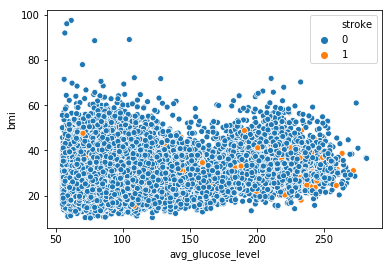

In [10]:
sns.scatterplot(x=train['avg_glucose_level'], y=train['bmi'],hue=train['stroke'])

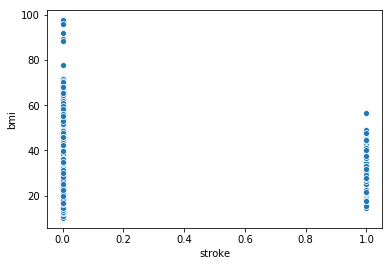

In [11]:
sns.scatterplot(x=train['stroke'], y=train['bmi'])

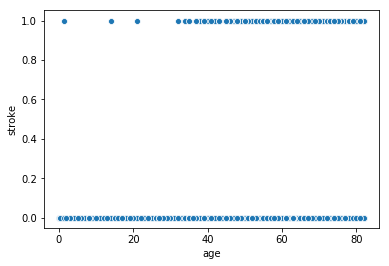

In [12]:
sns.scatterplot(x=train['age'], y=train['stroke'])

In [13]:
#in this previous two plots can see the dependence

In [14]:
train['stroke'].fillna('nan').value_counts()

0    29471
1      530
Name: stroke, dtype: int64

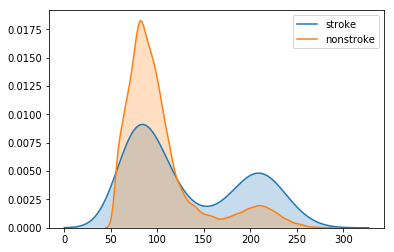

In [15]:
sns.kdeplot(data=train.loc[train['stroke']==1,'avg_glucose_level'], label="stroke", shade=True)
sns.kdeplot(data=train.loc[train['stroke']==0,'avg_glucose_level'], label="nonstroke", shade=True)

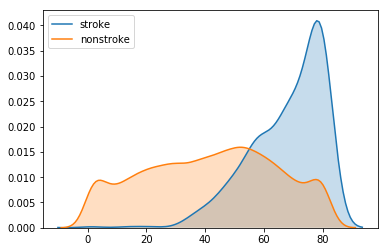

In [16]:
sns.kdeplot(data=train.loc[train['stroke']==1,'age'], label="stroke", shade=True)
sns.kdeplot(data=train.loc[train['stroke']==0,'age'], label="nonstroke", shade=True)

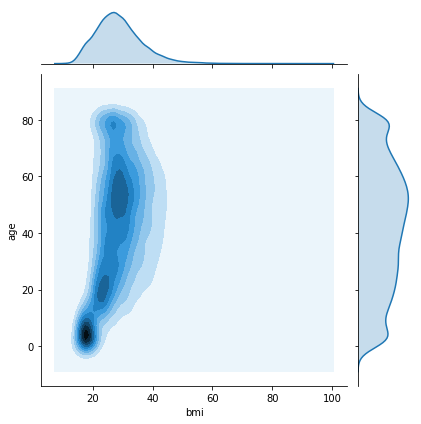

In [17]:
sns.jointplot(x=train['bmi'], y=train['age'], kind="kde")

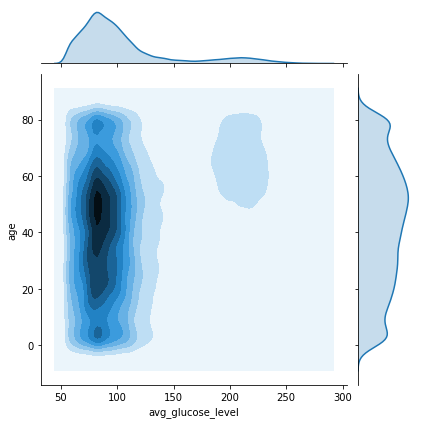

In [18]:
sns.jointplot(x=train['avg_glucose_level'], y=train['age'], kind="kde")

In [19]:
train['smoking_status'].fillna('nan').value_counts()

never smoked       11079
nan                 9176
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

In [20]:
train['Residence_type'].fillna('nan').value_counts()

Urban    15028
Rural    14973
Name: Residence_type, dtype: int64

In [21]:
#updatig column residence type, via dictionary

In [22]:
Residence_type_dict = {'Rural': 1, 'Urban':0 }

In [23]:
train['Residence_type'] =train['Residence_type'].replace(Residence_type_dict)
test['Residence_type'] = test['Residence_type'].replace(Residence_type_dict)

In [24]:
#updatig column bmi, use mean values

In [25]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

In [26]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,37061,Male,19.0,0,0,No,Private,1,92.61,16.8,never smoked
1,42333,Male,53.0,0,0,Yes,Govt_job,0,94.03,26.5,NaN
2,58964,Female,51.0,0,0,Yes,Private,1,127.22,31.0,smokes
3,34063,Female,17.0,0,0,No,Private,1,112.15,19.8,NaN
4,43682,Female,41.0,0,0,Yes,Govt_job,0,112.17,27.5,never smoked


In [27]:
#updatig column work type, via target encoding and dictionary

In [28]:
train['work_type'].fillna('nan').value_counts()

Private          17220
Self-employed     4674
children          4188
Govt_job          3804
Never_worked       115
Name: work_type, dtype: int64

In [29]:
(train.groupby(['work_type'])['stroke'].agg(['mean'])).to_dict()

{'mean': {'Govt_job': 0.017350157728706624,
  'Never_worked': 0.0,
  'Private': 0.018118466898954706,
  'Self-employed': 0.03209242618741977,
  'children': 0.0004775549188156638}}

In [30]:
work_type_target_enc_dict = (train.groupby(['work_type'])['stroke'].agg(['mean'])).to_dict()['mean']

In [31]:
work_type_target_enc_dict

{'Govt_job': 0.017350157728706624,
 'Never_worked': 0.0,
 'Private': 0.018118466898954706,
 'Self-employed': 0.03209242618741977,
 'children': 0.0004775549188156638}

In [32]:
train['work_type_target_enc'] = train['work_type'].replace(work_type_target_enc_dict)
test['work_type_target_enc'] = test['work_type'].replace(work_type_target_enc_dict)

In [33]:
for i in train['work_type'].unique():
    print(i)
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

children
Private
Never_worked
Self-employed
Govt_job


In [34]:
work_type_dict = {'Govt_job' : 2, 'Private' : 2,'Self-employed': 1,'Never_worked': 1, 'children':0 }

In [35]:
train['work_type'] =train['work_type'].replace(work_type_dict)
test['work_type'] = test['work_type'].replace(work_type_dict)

In [36]:
#updatig column gender, via target encoding and dictionary

In [37]:
gender_dict = {'Male': 0, 'Female':2, 'Other': 1 }

In [38]:
train['gender'].fillna('nan').value_counts()

Female    17676
Male      12315
Other        10
Name: gender, dtype: int64

In [39]:
(train.groupby(['gender'])['stroke'].agg(['mean']))

,mean
gender,
Female,0.016576
Male,0.019245
Other,0.000000


In [40]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']

train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)

In [41]:
train['gender'] =train['gender'].replace(gender_dict)
test['gender'] = test['gender'].replace(gender_dict)

In [42]:
#updatig column ever married, via  dictionary 

In [43]:
train['ever_married'].value_counts()

Yes    19376
No     10625
Name: ever_married, dtype: int64

In [44]:
ever_married_dict = {'Yes': 1, 'No':0 }

In [45]:
train['ever_married'] =train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

In [46]:
#updatig column smoking_status, via target encoding, mean and dictionary 
#as result not able to use all mathods, so choose one

In [47]:
train['smoking_status'].unique()

array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)

In [48]:
train['smoking_status'].value_counts()

never smoked       11079
formerly smoked     5183
smokes              4563
Name: smoking_status, dtype: int64

In [49]:
smoking_status_dict = {'smokes': 2,'formerly smoked': 1, 'never smoked':0 }

In [50]:
train['smoking_status'] = train['smoking_status'].replace(smoking_status_dict)
test['smoking_status'] = test['smoking_status'].replace(smoking_status_dict)

In [51]:
mean_smoking_status = train['smoking_status'].mean()

In [52]:
train.loc[train['age']<15,'smoking_status'] = 0
test.loc[test['age']<15,'smoking_status'] = 0

train['smoking_status'] = train['smoking_status'].fillna(mean_smoking_status)
test['smoking_status'] = test['smoking_status'].fillna(mean_smoking_status)

In [53]:
#train['smoking_status'] = train['smoking_status'].fillna('nan')
#test['smoking_status'] = test['smoking_status'].fillna('nan')

In [54]:
#(train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()

In [55]:
#smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']

In [56]:
#smoking_status_target_enc_dict

In [57]:
#train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
#test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)

In [58]:
#finally use dict and mean values as this gives higher score

In [59]:
#create some list of features

In [60]:
features = ['age', 'ever_married','avg_glucose_level','heart_disease','hypertension', 'bmi', 'smoking_status', 'Residence_type']

In [61]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_target_enc,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,gender_target_enc
0,37061,0,19.0,0,0,0,2,1,92.61,16.8,0.000000,0.018118,0,1,0,0,0,0.019245
1,42333,0,53.0,0,0,1,2,0,94.03,26.5,0.687107,0.017350,0,0,0,0,1,0.019245
2,58964,2,51.0,0,0,1,2,1,127.22,31.0,2.000000,0.018118,0,1,0,0,0,0.016576
3,34063,2,17.0,0,0,0,2,1,112.15,19.8,0.687107,0.018118,0,1,0,0,0,0.016576
4,43682,2,41.0,0,0,1,2,0,112.17,27.5,0.000000,0.017350,0,0,0,0,1,0.016576


In [62]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

In [63]:
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
from lightgbm import LGBMClassifier

In [66]:
lgb =   LGBMClassifier(n_estimators=100, max_depth=5)

In [67]:
#defining function for cross validation

In [68]:
def my_cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
        
    return scores


In [69]:
# here use clf 

In [70]:
scores = my_cross_validation_for_roc_auc(clf, train[features] , train['stroke'])


In [71]:
scores

[0.8339836864065939,
 0.8340942163380602,
 0.843212758299458,
 0.8385714740251027,
 0.8411988147087485]

In [72]:
np.mean(scores)

0.8382121899555927

In [73]:
#here use lgb

In [74]:
scores = my_cross_validation_for_roc_auc(lgb, train[features] , train['stroke'])

In [75]:
scores

[0.8402518920140065,
 0.8505410381689126,
 0.8452558646680217,
 0.8326188213388004,
 0.8406442611740625]

In [76]:
np.mean(scores)

0.8418623754727609

In [77]:
#put all features obtained previosly in a list

In [78]:
all_features = [ 'age', 'hypertension', 'heart_disease', 'ever_married',
        'Residence_type', 'avg_glucose_level', 'bmi','work_type','work_type_target_enc','work_type_is_children',
       'work_type_is_Private', 'work_type_is_Never_worked','work_type_is_Self-employed',
        'work_type_is_Govt_job','smoking_status', 'gender_target_enc','gender']

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=30)

In [80]:
#for clf choosing usefull parameters

In [81]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(clf, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8366076869311634
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.4904924945114688
avg_glucose_level 0.6135333190610858
bmi 0.5
work_type 0.527025323981953
work_type_target_enc 0.6158517888360108
work_type_is_children 0.5689884334400628
work_type_is_Private 0.4976360927468386
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.5
smoking_status 0.5695685893804613
gender_target_enc 0.5
gender 0.5108378710859861


In [82]:
features_2 = ['age','work_type', 'gender','ever_married','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension','smoking_status']

In [83]:
scores = my_cross_validation_for_roc_auc(clf, train[features_2] , train['stroke'])

In [84]:
scores

[0.833442866482514,
 0.8462375734098244,
 0.8464988425925927,
 0.8380167415762978,
 0.8404461517044298]

In [85]:
np.mean(scores)

0.8409284351531318

In [86]:
clf = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

clf.fit(train[features_2], train['stroke'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
clf.predict_proba(test[features_2])

array([[1.00000000e+000, 3.57426467e-103],
       [1.00000000e+000, 1.04944307e-054],
       [1.00000000e+000, 7.35220126e-051],
       ...,
       [1.00000000e+000, 5.11292544e-012],
       [1.00000000e+000, 1.45316759e-073],
       [1.00000000e+000, 7.54415234e-018]])

In [88]:
prediction = clf.predict_proba(test[features_2])[:,1]

In [ ]:
#Kaggle score is 0,8545

In [89]:
sample['stroke'] = prediction

In [90]:
sample.to_csv('submit_ex.csv', index = None )

In [91]:
#for lgb choosing usefull parameters

In [92]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(lgb, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8253239939153151
hypertension 0.581615320246325
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.49321198951765294
avg_glucose_level 0.6056095800245963
bmi 0.6082876646641866
work_type 0.6109515428981726
work_type_target_enc 0.6068049732633557
work_type_is_children 0.5689884334400628
work_type_is_Private 0.48643144589553095
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.4889896401849564
smoking_status 0.5825497188213402
gender_target_enc 0.5181527344280619
gender 0.5182457044555294


In [93]:
features_3 = ['age', 'ever_married','work_type','gender','gender_target_enc','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension', 'bmi', 'smoking_status']

In [94]:
scores = my_cross_validation_for_roc_auc(lgb, train[features_3] , train['stroke'])

In [95]:
scores

[0.844118925616723,
 0.8479269015221574,
 0.8412852162375791,
 0.8332288886952167,
 0.8350765436858152]

In [96]:
np.mean(scores)

0.8403272951514982

In [97]:
lgb.fit(train[features_3], train['stroke'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [98]:
lgb.predict_proba(test[features_3])

array([[9.99989677e-01, 1.03230372e-05],
       [9.92441143e-01, 7.55885666e-03],
       [9.82453259e-01, 1.75467411e-02],
       ...,
       [9.36873572e-01, 6.31264282e-02],
       [9.99036140e-01, 9.63859552e-04],
       [9.12875776e-01, 8.71242237e-02]])

In [99]:
prediction = lgb.predict_proba(test[features_3])[:,1]

In [ ]:
#Kaggle score is 0,8516

In [100]:
sample['stroke'] = prediction

In [101]:
#sample.to_csv('submit_ex.csv', index = None )

In [102]:
#for knn choosing usefull parameters, additionally explored different n_neighbors number, not included here

In [103]:
knn = KNeighborsClassifier(n_neighbors=200)

In [104]:
features_scores = {}
for f in all_features:
    scores = my_cross_validation_for_roc_auc(knn, train[[f]] , train['stroke'])
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.810722097942499
hypertension 0.5630853920247668
heart_disease 0.5818777239077606
ever_married 0.6259899654630761
Residence_type 0.5106179219039293
avg_glucose_level 0.606038102819818
bmi 0.5915853775556219
work_type 0.5582452272043009
work_type_target_enc 0.6015425246817994
work_type_is_children 0.5689884334400628
work_type_is_Private 0.48643144589553095
work_type_is_Never_worked 0.5019511976545372
work_type_is_Self-employed 0.5634987850302702
work_type_is_Govt_job 0.49791657336522077
smoking_status 0.4947235479650324
gender_target_enc 0.5110126168682684
gender 0.5058303218299602


In [105]:
features_4 = ['age', 'ever_married','work_type','gender','gender_target_enc','Residence_type','avg_glucose_level','heart_disease','work_type_target_enc','work_type_is_children','work_type_is_Self-employed','hypertension', 'bmi','smoking_status']

In [106]:
scores = my_cross_validation_for_roc_auc(knn, train[features_4] , train['stroke'])

In [107]:
scores

[0.8307832647039696,
 0.8332952891830969,
 0.8324608669263776,
 0.8394298567794254,
 0.8364128264790517]

In [108]:
np.mean(scores)

0.8344764208143841

In [109]:
knn.fit(train[features_4], train['stroke'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [110]:
knn.predict_proba(test[features_4])

array([[1.   , 0.   ],
       [0.98 , 0.02 ],
       [0.995, 0.005],
       ...,
       [0.945, 0.055],
       [0.995, 0.005],
       [0.915, 0.085]])

In [111]:
prediction = knn.predict_proba(test[features_4])[:,1]

In [ ]:
#Kaggle score is 0,839

In [112]:
sample['stroke'] = prediction

In [113]:
#sample.to_csv('submit_ex.csv', index = None )